# Réseau de neurones

In [11]:
# Installation et chargement des requirements
%pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

Note: you may need to restart the kernel to use updated packages.


## 1. PRÉPARATION DES DONNÉES POUR LA CLASSIFICATION

In [3]:
# Chargement des données
# On lit le fichier CSV créé précédemment.
df = pd.read_csv("all_expenses_profil.csv")

# Définition de la cible (Classification)
y = df["profil"]

# Définition des features
#  On retire 'TOTEXP23' (car c'est la réponse), 'profil' (la cible), 'DUPERSID' (ID), 
# et 'cum_cost_share' (variable intermédiaire de construction)
X = df.drop(["TOTEXP23", "profil", "DUPERSID", "cum_cost_share"], axis=1, errors="ignore")

# Split Train/Test
#  stratify=y est utile ici pour garder la même proportion  de classes (0, 1, 2) dans le train et le test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Preprocessing (Reprise du preprocess3)
num_vars = X.select_dtypes(include=["int64", "float64"]).columns
cat_vars = X.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler())
])

# sparse_output=False est nécessaire pour que ça sorte une matrice dense compatible avec Keras
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess3 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)

print("Transformation des données...")
X_train_preproc = preprocess3.fit_transform(X_train).astype('float32')
X_test_preproc = preprocess3.transform(X_test).astype('float32')

# Conversion des cibles en tableau numpy
y_train_arr = np.array(y_train).astype('float32')
y_test_arr = np.array(y_test).astype('float32')

input_shape = X_train_preproc.shape[1]
nb_classes = 3 # Car profil = 0, 1, 2
print(f"Input shape: {input_shape}, Nombre de classes: {nb_classes}")

Transformation des données...
Input shape: 128, Nombre de classes: 3


## 2. ARCHITECTURE DU MODÈLE DE CLASSIFICATION

In [ ]:
def build_classification_model(input_dim):
    model = models.Sequential()
    
    # Couche cachée 1
    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Couche cachée 2
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    
    # Couche de sortie (CLASSIFICATION)
    # Activation 'softmax' pour avoir une probabilité pour chaque classe
    # 3 neurones car 3 classes de profil
    model.add(layers.Dense(3, activation='softmax'))
    
    # Compilation
    # sparse_categorical_crossentropy : car y est un entier (0, 1, 2)
    # Si y était one-hot encoded, on utiliserait categorical_crossentropy
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = build_classification_model(input_shape)
model.summary()

/opt/python/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-05 08:41:09.915009: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,819 (42.26 KB)

 Trainable params: 10,627 (41.51 KB)

 Non-trainable params: 192 (768.00 B)

ANALYSE DE L'ARCHITECTURE (Interprétation du summary) :

1. Structure en "Entonnoir" :
   - Le modèle réduit progressivement la complexité : 64 -> 32 -> 3 neurones.
   - Cela force le réseau à synthétiser l'information et extraire les traits essentiels.

2. Origine des Paramètres (Total : ~10 819) :
   - Couche Dense 1 (8 256 params) : Le calcul est (Nb Features + 1 biais) * 64.
     Cela confirme que nous avons environ 128 variables en entrée après le preprocessing.
   - Couche Dense 2 (2 080 params) : (64 + 1) * 32.
   - Sortie (99 params) : (32 + 1) * 3 classes.

3. Paramètres Non-Entraînables (192) :
   - Ils proviennent exclusivement des couches BatchNormalization.
   - Ce sont des statistiques (moyenne, variance) calculées sur les données passantes
     et non apprises par la descente de gradient (backpropagation).

4. Conclusion sur le Dimensionnement :
   - Avec ~10k paramètres pour un jeu d'entraînement d'environ 6000 individus,
     le modèle est bien dimensionné (ni trop simple, ni trop complexe), limitant
     le risque de sur-apprentissage (overfitting).


## 3. ENTRAÎNEMENT

In [5]:

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

print("\nDébut de l'entraînement...")
history = model.fit(
    X_train_preproc, y_train_arr,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Début de l'entraînement...
Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5443 - loss: 1.1613 - val_accuracy: 0.7833 - val_loss: 0.7199
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7394 - loss: 0.7889 - val_accuracy: 0.7930 - val_loss: 0.6647
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7808 - loss: 0.7085 - val_accuracy: 0.7956 - val_loss: 0.6644
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7867 - loss: 0.6880 - val_accuracy: 0.7930 - val_loss: 0.6604
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7911 - loss: 0.6821 - val_accuracy: 0.7921 - val_loss: 0.6601
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7905 - loss: 0.6702 - val_accuracy: 0.7947 - val_loss: 0.6549
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7955 - loss: 0.6576 - val_accuracy: 0.7956 - val_loss: 0.6524
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7973 - los

## 4. ÉVALUATION

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


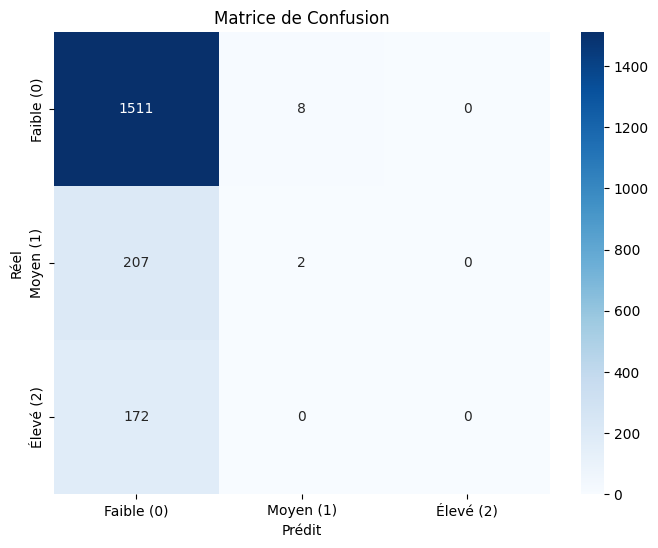

In [7]:
# --- Matrice de Confusion ---
# On récupère les probabilités prédites
y_pred_probs = model.predict(X_test_preproc)
# On prend l'index de la probabilité maximale (0, 1 ou 2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test_arr, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'],
            yticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

In [8]:
# Rapport détaillé
print("\nRapport de Classification :")
print(classification_report(y_test_arr, y_pred_classes, target_names=['Faible', 'Moyen', 'Élevé']))


Rapport de Classification :
              precision    recall  f1-score   support

      Faible       0.80      0.99      0.89      1519
       Moyen       0.20      0.01      0.02       209
       Élevé       0.00      0.00      0.00       172

    accuracy                           0.80      1900
   macro avg       0.33      0.33      0.30      1900
weighted avg       0.66      0.80      0.71      1900



/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [15]:
# Calcul de la nouvelle métrique pertinente
macro_f1 = f1_score(y_test_arr, y_pred_classes, average='macro')
print(f"\n>>> Nouvelle Métrique : Macro F1-Score {macro_f1:.4f}")


>>> Nouvelle Métrique : Macro F1-Score 0.3016


ANALYSE DES RÉSULTATS :

1. Le problème du déséquilibre :
   - Le rapport montre que la classe "Faible" représente ~80% des données (Support élevé).
   - Les classes "Moyen" et "Élevé" sont très minoritaires (~10% chacune).

2. Comportement du modèle :
   - Le modèle est "paresseux" : il prédit "Faible" pour presque tout le monde.
   - Accuracy (~0.80) : Elle semble bonne uniquement parce que prédire "Faible" marche 80% du temps.
   - Recall pour "Élevé" (0.00) : Le modèle rate 100% des patients les plus coûteux.
   - Macro F1 (~0.30) : Ce chiffre confirme l'échec. C'est la moyenne de (0.90, 0.00, 0.00). 
     Le modèle performe bien sur une seule classe sur trois.

3. Conclusion :
   - Pour un assureur ou un hôpital, ce modèle est inutile car il échoue à identifier 
     les risques élevés.
   - Solution : Il faut forcer le modèle à accorder plus d'importance aux erreurs sur 
     les classes minoritaires (Moyen/Élevé).

## 5. AMÉLIORATION DU MODÈLE : GESTION DU DÉSÉQUILIBRE (CLASS WEIGHTS)

Poids des classes calculés : {0: np.float64(0.416794674859191), 1: np.float64(3.0389333333333335), 2: np.float64(3.6808785529715764)}
Le modèle sera désormais plus pénalisé s'il se trompe sur les classes 1 et 2.
Epoch 1/60


/opt/python/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2835 - loss: 1.4367 - val_accuracy: 0.3158 - val_loss: 1.1069
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2957 - loss: 1.2550 - val_accuracy: 0.2482 - val_loss: 1.0987
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3039 - loss: 1.1829 - val_accuracy: 0.2649 - val_loss: 1.0866
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3223 - loss: 1.1510 - val_accuracy: 0.1974 - val_loss: 1.0914
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3214 - loss: 1.1391 - val_accuracy: 0.1921 - val_loss: 1.0988
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3199 - loss: 1.1199 - val_accuracy: 0.1623 - val_loss: 1.1052
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3137 - loss: 1.1056 - val_accuracy: 0.2500 - val_loss: 1.0924
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3159 - loss: 1.0838 - val_accuracy: 0.1982 - val_

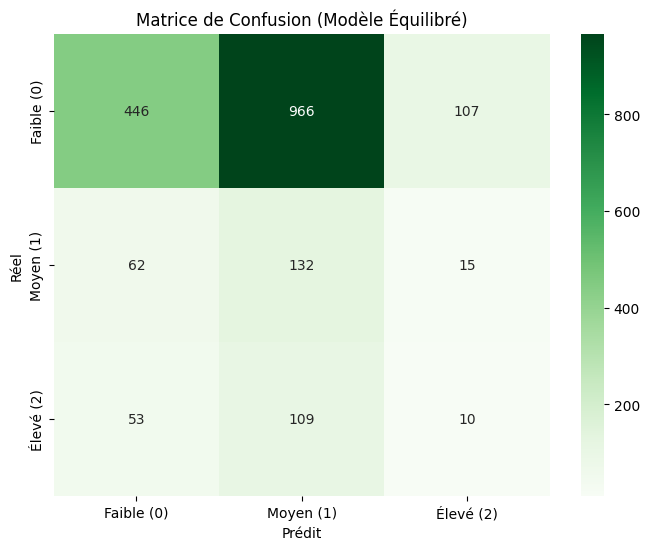

In [14]:
# 1. Calcul des poids pour chaque classe
# Cela donne plus de poids aux classes rares (Moyen/Élevé) et moins à la classe fréquente (Faible)
class_weights_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_arr),
    y=y_train_arr
)
# Création du dictionnaire {0: poids_0, 1: poids_1, 2: poids_2}
class_weights_dict = dict(enumerate(class_weights_vals))

print(f"Poids des classes calculés : {class_weights_dict}")
print("Le modèle sera désormais plus pénalisé s'il se trompe sur les classes 1 et 2.")

# 2. Re-création d'un modèle vierge (même architecture)
model_balanced = build_classification_model(input_shape)

# 3. Entraînement avec les poids (class_weight)
history_balanced = model_balanced.fit(
    X_train_preproc, y_train_arr,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict, # C'est ici que la magie opère
    verbose=1
)

# 4. Évaluation du modèle amélioré
y_pred_probs_bal = model_balanced.predict(X_test_preproc)
y_pred_classes_bal = np.argmax(y_pred_probs_bal, axis=1)

print("\nRapport de Classification (Modèle Amélioré/Équilibré) :")
print(classification_report(y_test_arr, y_pred_classes_bal, target_names=['Faible', 'Moyen', 'Élevé']))

# Comparaison des métriques
new_macro_f1 = f1_score(y_test_arr, y_pred_classes_bal, average='macro')
print(f"\n>>> Macro F1-Score (Standard) : {macro_f1 if 'macro_f1' in locals() else 'N/A'}")
print(f">>> Macro F1-Score (Amélioré) : {new_macro_f1:.4f}")

# Matrice de confusion du modèle amélioré
cm_balanced = confusion_matrix(y_test_arr, y_pred_classes_bal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'],
            yticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion (Modèle Équilibré)')
plt.show()

Le modèle "Amélioré" a tellement peur de rater un patient "Élevé" qu'il classe tout le monde en "Moyen" ou "Élevé".

Il ne détecte plus que 29% des vrais patients "Faibles".

Les 71% restants sont des Faux Positifs (des gens sains classés comme coûteux).

Résultat : Le modèle est devenu hyper-alarmiste et donc peu fiable.